In [1]:
# 1. DATA PREPARATION 
import numpy as np
import pandas as pd

### Read in data
bes_data = pd.read_csv("bes_data_nov19.csv")

In [2]:
### Explore with pandas-profiling summary
import pandas_profiling

pandas_profiling.ProfileReport(bes_data)

In [3]:
bes_data.shape

(1591, 15)

In [4]:
bes_data.party_identity.value_counts()
# 0 None / No party/ uncommitted
# 1 Labour
# 2 Conservative
# 3 Liberal Democrat
# 4 Scottish National Party (SNP)
# 5 Plaid Cymru
# 6 Green Party
# 7 United Kingdom Independence Party (UKIP)

1    646
2    511
0    212
3    105
7     43
4     39
6     24
5     11
Name: party_identity, dtype: int64

In [5]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

bes_data.age = ordinal_encoder.fit_transform(bes_data.age.values.reshape(-1, 1))
bes_data.income = ordinal_encoder.fit_transform(bes_data.income.values.reshape(-1, 1))
bes_data.education = ordinal_encoder.fit_transform(bes_data.education.values.reshape(-1, 1))

In [6]:
bes_data.head()

,age,income,living_situation,work_status,education,party_identity,religion,ethnicity,union_member,social_class,region,gender,marital_status,eu_vote,ability
0,0.0,2.0,own on mortgage,full time,0.0,1,No religion,White,0,Working class,East Midlands,0,Single,Leave,-0.282726
1,3.0,1.0,rent local authority,looking after family or home,2.0,1,Muslim,Asian,0,Working class,East Midlands,1,Single,Remain,-0.282726
2,5.0,8.0,own outright,retired,0.0,1,Christian - no denomination,White,0,Working class,East Midlands,0,Married,Leave,-0.306999
3,5.0,9.0,own outright,retired,7.0,1,Christian - no denomination,White,0,Working class,East Midlands,0,Married,Remain,0.847357
4,5.0,3.0,own outright,part time,0.0,2,Christian - no denomination,White,0,None,East Midlands,1,Married,Remain,0.079292


In [7]:
bes_data.age.value_counts()
# 0 = 18-24
# 1 = 25-34
# 2 = 35-44
# 3 = 45-54
# 4 = 55-64
# 5 = 65-74
# 6 = 75-84
# 7 = 85+

4.0    285
3.0    283
5.0    272
2.0    238
1.0    218
6.0    143
0.0    103
7.0     49
Name: age, dtype: int64

In [8]:
bes_data.income.value_counts()
# 0 = Under GBP 2,600
# 1 = GBP 2,600 - GBP 5,199
# 2 = GBP 5,200 - GBP 10,399
# 3 = GBP 10,400 - GBP 15,599
# 4 = GBP 15,600 - GBP 20,799
# 5 = GBP 20,800 - GBP 25,999
# 6 = GBP 26,000 - GBP 31,199
# 7 = GBP 31,200 - GBP 36,399
# 8 = GBP 36,400 - GBP 39,999
# 9 = GBP 40,000 - GBP 44,999
# 10 = GBP 45,000 - GBP 49,999
# 11 = GBP 50,000 - GBP 59,999
# 12 = GBP 60,000 - GBP 74,999
# 13 = GBP 75,000 - GBP 99,999
# 14 = GBP 100,000 or more

3.0     180
4.0     160
5.0     157
6.0     150
2.0     131
7.0     107
12.0    106
11.0    102
13.0    100
10.0     92
8.0      89
9.0      73
14.0     71
1.0      44
0.0      29
Name: income, dtype: int64

In [9]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(dtype=np.int, sparse=True)

living_situation = pd.DataFrame(
    onehot.fit_transform(bes_data[['living_situation']])\
    .toarray(),
    columns=['own outright', 'own on mortgage', 'rent private', 'rent local authority', 'housing assoc'])

work_status = pd.DataFrame(
    onehot.fit_transform(bes_data[['work_status']])\
    .toarray(),
    columns=['full time', 'part time', 'unemployed', 'student', 'retired', 'looking after family or home'])

religion = pd.DataFrame(
    onehot.fit_transform(bes_data[['religion']])\
    .toarray(),
    columns=['Christian - no denomination', 'Church of England or Anglican', 'Hindu', 'Muslim', 'No religion', 'Other', 'Roman Catholic'])

ethnicity = pd.DataFrame(
    onehot.fit_transform(bes_data[['ethnicity']])\
    .toarray(),
    columns=['White', 'Asian', 'Black', 'Mixed', 'Other'])

social_class = pd.DataFrame(
    onehot.fit_transform(bes_data[['social_class']])\
    .toarray(),
    columns=['Working class', 'Middle class', 'Other', 'None'])

region = pd.DataFrame(
    onehot.fit_transform(bes_data[['region']])\
    .toarray(),
    columns=['East Midlands', 'Eastern', 'London', 'North East','North West','Scotland','South East','South West','Wales','West Midlands','Yorkshire & Humber'])

marital_status = pd.DataFrame(
    onehot.fit_transform(bes_data[['marital_status']])\
    .toarray(),
    columns=['Divorced', 'Living with partner', 'Married', 'Separated', 'Single', 'Widowed'])

eu_vote = pd.DataFrame(
    onehot.fit_transform(bes_data[['eu_vote']])\
    .toarray(),
    columns=['Leave', 'Remain', 'Did not vote'])


In [10]:
bes_data = pd.concat([bes_data, living_situation, work_status, religion, ethnicity, social_class, region, marital_status, eu_vote], axis=1, sort=False)
bes_data = bes_data.drop(['living_situation', 'work_status', 'religion', 'ethnicity', 'social_class', 'region', 'marital_status', 'eu_vote'], axis=1)
bes_data.head()

,age,income,education,party_identity,union_member,gender,ability,own outright,own on mortgage,rent private,...,Yorkshire & Humber,Divorced,Living with partner,Married,Separated,Single,Widowed,Leave,Remain,Did not vote
0,0.0,2.0,0.0,1,0,0,-0.282726,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,3.0,1.0,2.0,1,0,1,-0.282726,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,5.0,8.0,0.0,1,0,0,-0.306999,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,5.0,9.0,7.0,1,0,0,0.847357,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,5.0,3.0,0.0,2,0,1,0.079292,0,0,1,...,0,0,0,1,0,0,0,0,0,1


In [11]:
### Prepare train and test sets for three regression models

from sklearn.model_selection import train_test_split

y = bes_data['party_identity']

X_demographic = bes_data.drop(['party_identity', 'Leave', 'Remain', 'Did not vote'], axis=1)
X_demographic_train, X_demographic_test, y_demographic_train, y_demographic_test = train_test_split(X_demographic, y, test_size = 0.2, random_state = 42)

X_euVote = bes_data.drop(['party_identity'], axis=1)
X_euVote_train, X_euVote_test, y_euVote_train, y_euVote_test = train_test_split(X_euVote, y, test_size = 0.2, random_state = 42)

In [12]:
X_demographic_train.head()

,age,income,education,union_member,gender,ability,own outright,own on mortgage,rent private,rent local authority,...,South West,Wales,West Midlands,Yorkshire & Humber,Divorced,Living with partner,Married,Separated,Single,Widowed
701,3.0,6.0,0.0,0,0,0.847357,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1480,5.0,4.0,4.0,0,1,0.298944,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
528,4.0,13.0,0.0,0,1,0.384452,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
988,6.0,1.0,0.0,0,0,-1.196491,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1416,6.0,4.0,3.0,0,1,0.298944,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0


In [13]:
X_demographic_train.shape[0]

1272

In [14]:
y_demographic_train.head()

701     4
1480    2
528     2
988     0
1416    1
Name: party_identity, dtype: int64

In [15]:
y_demographic_train.shape

(1272,)

In [16]:
# 2. TWO MULTINOMIAL LOGISTIC REGRESSION (SOFTMAX) MODELS

from sklearn.linear_model import LogisticRegression

softmax_reg_demographic = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100000, random_state=42)
softmax_reg_demographic.fit(X_demographic_train, y_demographic_train)

softmax_reg_euVote = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=100000, random_state=42)
softmax_reg_euVote.fit(X_euVote_train, y_euVote_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
### For illustration, predict probabilites on first observation
actual_prob = softmax_reg_demographic.predict_proba([X_demographic_train.iloc[0,:]])
actual_prob

array([[7.40587578e-02, 1.52782939e-01, 1.83732526e-01, 2.39187000e-02,
        5.51221253e-01, 1.60482003e-04, 3.46385660e-03, 1.06614864e-02]])

In [18]:
y_demographic_train.iloc[0]

4

<IPython.core.display.Javascript object>


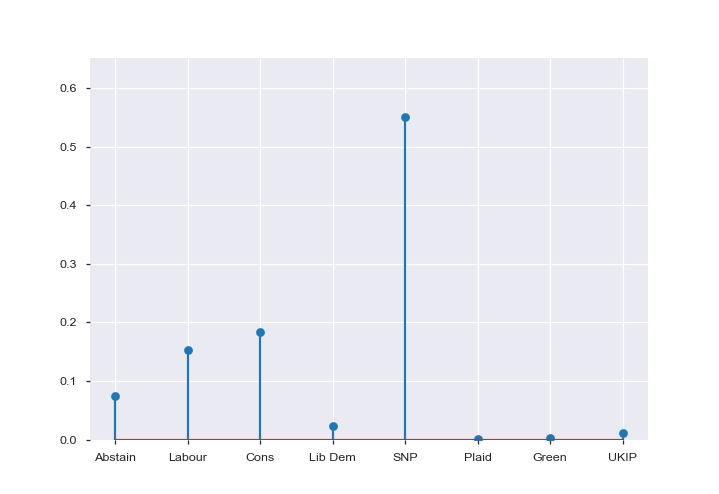

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
 
plt.stem(x, actual_prob.tolist()[0], use_line_collection=True)
plt.ylim(0, max(actual_prob.tolist()[0]) + 0.1)
plt.show()

In [20]:
# 3. MODEL EVALUATION

### Classification accuracy

demographic_acc = softmax_reg_demographic.score(X_demographic_test,y_demographic_test)

from sklearn.dummy import DummyClassifier

dummy_demographic_model = DummyClassifier()
dummy_demographic_model.fit(X_demographic_train, y_demographic_train)
dummy_demographic_acc = dummy_demographic_model.score(X_demographic_test,y_demographic_test)

euVote_acc = softmax_reg_euVote.score(X_euVote_test,y_euVote_test)

dummy_euVote_model = DummyClassifier()
dummy_euVote_model.fit(X_euVote_train, y_euVote_train)
dummy_euVote_acc = dummy_euVote_model.score(X_euVote_test,y_euVote_test)

print("DEMOGRAPHIC MODELS:")
print("Demographic: ", demographic_acc)
print("Dummy: ", dummy_demographic_acc)
print("EU VOTE MODELS:")
print("EU vote: ", euVote_acc)
print("Dummy: ", dummy_euVote_acc)

DEMOGRAPHIC MODELS:
Demographic:  0.4952978056426332
Dummy:  0.28213166144200624
EU VOTE MODELS:
EU vote:  0.5015673981191222
Dummy:  0.2727272727272727


In [21]:
### Log-loss
from sklearn.metrics import log_loss

y_pred_demo = softmax_reg_demographic.predict_proba(X_demographic_test)
logloss_demo = log_loss(y_demographic_test, y_pred_demo, labels=[0,1,2,3,4,5,6,7])

y_pred_eu = softmax_reg_euVote.predict_proba(X_euVote_test)
logloss_eu = log_loss(y_euVote_test, y_pred_eu, labels=[0,1,2,3,4,5,6,7])

def display_loglosses(dem,eu):
    print("LOG-LOSSES:")
    print("Demographic Model:", logloss_demo)
    print("EU Vote Model:", logloss_eu)

display_loglosses(logloss_demo, logloss_eu)

LOG-LOSSES:
Demographic Model: 1.313558455514277
EU Vote Model: 1.2730419887277347


In [22]:
### For context, a (very) dumb log-loss on 8 classes is -log(1/8), given balanced classes

import math

print("VERY DUMB LOG-LOSS:")
print(-math.log(1/8)) 

### Calculate a (less) dumb log-loss for unbalanced case that simply uses base rates
### (Since all train sets contain the same observations, only one set needs to be used here)

all_votes = y_demographic_train.value_counts().sum()

y_demographic_train.value_counts()[0]

novote = y_demographic_train.value_counts()[0]/all_votes
labour = y_demographic_train.value_counts()[1]/all_votes
cons = y_demographic_train.value_counts()[2]/all_votes
libdem = y_demographic_train.value_counts()[3]/all_votes
snp = y_demographic_train.value_counts()[4]/all_votes
plaid = y_demographic_train.value_counts()[5]/all_votes
green = y_demographic_train.value_counts()[6]/all_votes
ukip = y_demographic_train.value_counts()[7]/all_votes

y_array = np.array([novote,labour,cons,libdem,snp,plaid,green,ukip])
y_array_tiled = np.tile(y_array,(y_demographic_test.shape[0],1))
logloss_dumb = log_loss(y_demographic_test, y_array_tiled,labels=[0,1,2,3,4,5,6,7])

print("LESS DUMB LOG-LOSS:")
print(logloss_dumb)

VERY DUMB LOG-LOSS:
2.0794415416798357
LESS DUMB LOG-LOSS:
1.4893560795840097


In [23]:
# 4. SIMULATION OF FULLY INFORMED (REPORTED) PREFERENCES

### Find maximum ability value
maxValue = bes_data['ability'].max()
maxValue

0.847356952624131

In [24]:
### Take first observation from test data as example
obs = X_demographic_test.iloc[0,:].copy()

### Assign max ability value to that observation
obs[5] = maxValue
obs

age                              0.000000
income                           4.000000
education                        3.000000
union_member                     0.000000
gender                           0.000000
ability                          0.847357
own outright                     0.000000
own on mortgage                  1.000000
rent private                     0.000000
rent local authority             0.000000
housing assoc                    0.000000
full time                        1.000000
part time                        0.000000
unemployed                       0.000000
student                          0.000000
retired                          0.000000
looking after family or home     0.000000
Christian - no denomination      1.000000
Church of England or Anglican    0.000000
Hindu                            0.000000
Muslim                           0.000000
No religion                      0.000000
Other                            0.000000
Roman Catholic                   0

In [25]:
### Predict informed vote using demographic model
softmax_reg_demographic.predict([obs])

array([2])

In [26]:
### Predict full probability distribution over all parties (and abstain) using same model
full_inf_prob = softmax_reg_demographic.predict_proba([obs])
full_inf_prob

array([[0.14065494, 0.17305775, 0.48409685, 0.16586344, 0.00674021,
        0.01107662, 0.01162472, 0.00688547]])

<IPython.core.display.Javascript object>


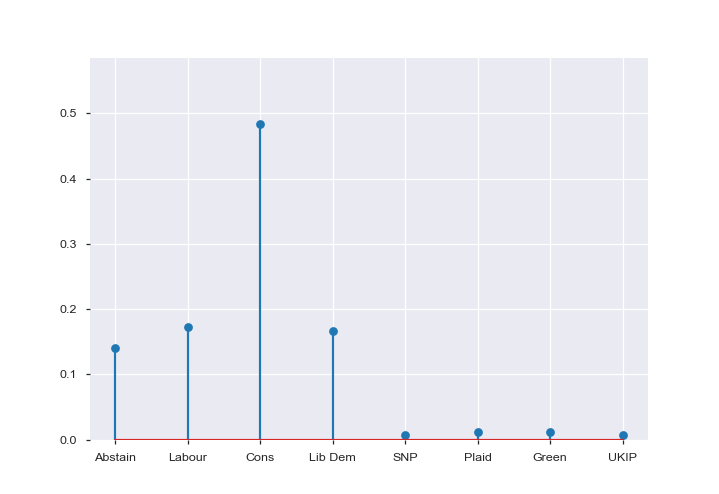

In [27]:
### Plot the distribution
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
values=full_inf_prob.tolist()[0]

plt.stem(x, values, use_line_collection=True)
plt.ylim(0, max(values) + 0.1)
plt.show()

In [28]:
# 5. DIFFERENCE BETWEEN ACTUAL AND FULLY INFORMED VOTE

### Calculate difference between the person's actual vote and their fully informed distribution
actual_vote = [0,0,0,0,0,0,0,0]
actual_vote[y_demographic_test.iloc[0]] = 1
prob_diff = np.subtract(full_inf_prob, actual_vote)
prob_diff

array([[ 0.14065494,  0.17305775, -0.51590315,  0.16586344,  0.00674021,
         0.01107662,  0.01162472,  0.00688547]])

<IPython.core.display.Javascript object>


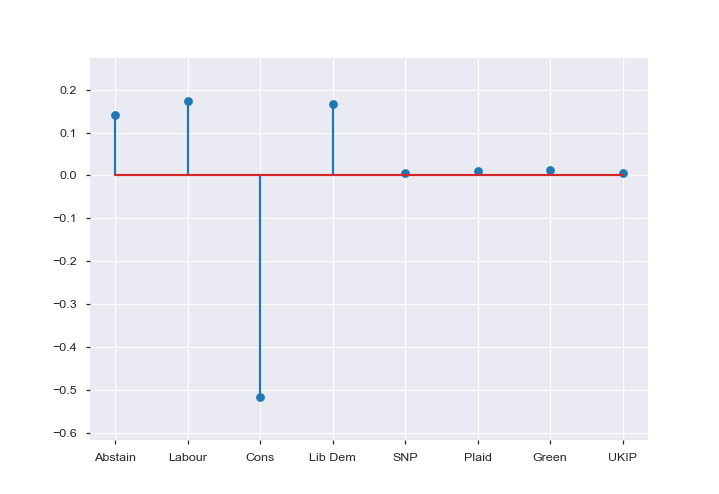

In [29]:
### Plot that difference
values=prob_diff.tolist()[0]

plt.stem(x, values, use_line_collection=True)
plt.ylim(min(prob_diff.tolist()[0]) - 0.1, max(prob_diff.tolist()[0]) + 0.1)
plt.show()

In [30]:
# 6. AGGREGATE DIFFERENCE BETWEEN ACTUAL AND FULLY INFORMED VOTES

### Calculate actual proportions of support
all_votes = bes_data['party_identity'].value_counts().sum()

novote = bes_data['party_identity'].value_counts()[0]/all_votes
lab = bes_data['party_identity'].value_counts()[1]/all_votes
cons = bes_data['party_identity'].value_counts()[2]/all_votes
libdem = bes_data['party_identity'].value_counts()[3]/all_votes
snp = bes_data['party_identity'].value_counts()[4]/all_votes
plaid = bes_data['party_identity'].value_counts()[5]/all_votes
green = bes_data['party_identity'].value_counts()[6]/all_votes
ukip = bes_data['party_identity'].value_counts()[7]/all_votes

<IPython.core.display.Javascript object>


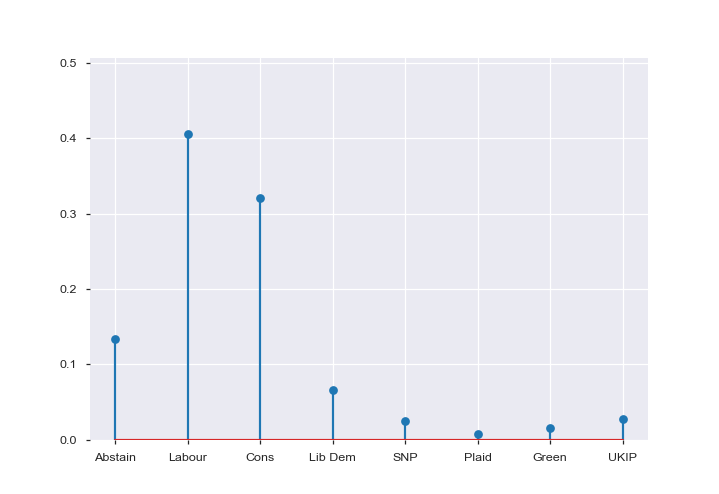

In [31]:
### Plot proportions of actual support
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
values_actual=[novote,lab,cons,libdem,snp,plaid,green,ukip,]
 
plt.stem(x, values_actual, use_line_collection=True)
plt.ylim(0, max(values_actual) + 0.1)
plt.show()

In [32]:
### Copy X and assign max ability value to all observations
all_obs = X_demographic_test.copy()
all_obs['ability'] = maxValue
all_obs.head()

,age,income,education,union_member,gender,ability,own outright,own on mortgage,rent private,rent local authority,...,South West,Wales,West Midlands,Yorkshire & Humber,Divorced,Living with partner,Married,Separated,Single,Widowed
1080,0.0,4.0,3.0,0,0,0.847357,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
405,3.0,4.0,1.0,0,0,0.847357,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1494,0.0,6.0,4.0,0,0,0.847357,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
239,6.0,4.0,0.0,0,0,0.847357,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
610,4.0,5.0,1.0,0,1,0.847357,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [33]:
### Calculate fully informed distribution for each observation
all_obs_full_inf = softmax_reg_demographic.predict_proba(all_obs)
all_obs_full_inf

array([[1.40654939e-01, 1.73057754e-01, 4.84096846e-01, ...,
        1.10766228e-02, 1.16247193e-02, 6.88546767e-03],
       [1.03608088e-01, 4.13001981e-01, 3.73864160e-01, ...,
        3.87256730e-03, 1.39202416e-03, 1.21894729e-02],
       [1.48415297e-01, 4.16390646e-01, 2.73010307e-01, ...,
        2.57892047e-04, 1.09766372e-01, 3.52665756e-03],
       ...,
       [2.98954073e-02, 3.55587465e-01, 5.83970567e-01, ...,
        2.08134156e-04, 9.58638612e-05, 1.63223819e-02],
       [5.89010847e-02, 3.03679157e-01, 4.99631856e-01, ...,
        2.49447924e-04, 7.19517159e-04, 6.96426577e-02],
       [5.58469995e-02, 4.66707778e-01, 2.52667367e-01, ...,
        1.75445414e-01, 2.67702102e-03, 1.33412725e-02]])

In [34]:
### Calculate the mean probability for each party (or abstain)
mean_full_inf = all_obs_full_inf.mean(axis = 0)

<IPython.core.display.Javascript object>


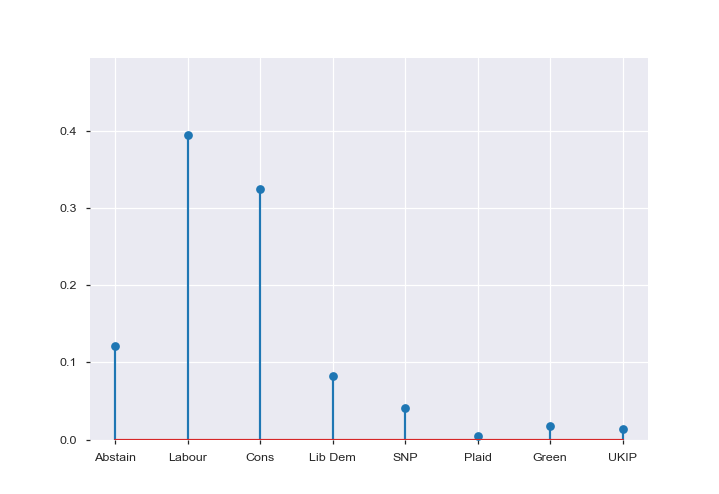

In [35]:
### Plot proportions of simulated fully informed support
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
values_sim=[mean_full_inf[0],mean_full_inf[1],mean_full_inf[2],mean_full_inf[3],mean_full_inf[4],mean_full_inf[5],mean_full_inf[6],mean_full_inf[7]]

plt.stem(x, values_sim, use_line_collection=True)
plt.ylim(0, max(values_sim) + 0.1)
plt.show()

In [36]:
values_sim

[0.12134231499230122,
 0.39440574094397274,
 0.3248215367433228,
 0.08183625105505914,
 0.04080157819317463,
 0.004837095578737694,
 0.017690003032166942,
 0.014265479461264469]

<IPython.core.display.Javascript object>


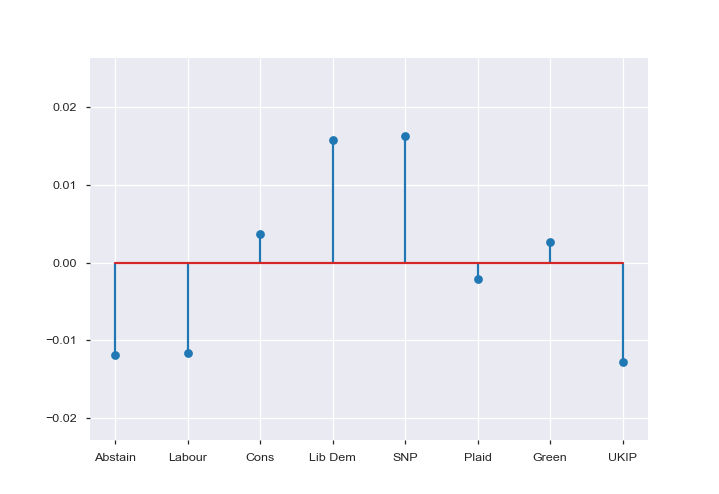

In [37]:
### Plot aggregate information effect, i.e., difference between actual and simulated support
x=["Abstain","Labour","Cons","Lib Dem","SNP","Plaid","Green","UKIP"]
support_diff = np.subtract(values_sim, values_actual)

plt.stem(x, support_diff, use_line_collection=True)
plt.ylim(min(support_diff) - 0.01, max(support_diff) + 0.01)
plt.show()